# Investigation of properties of the Nearest Advocate method for time delay estimation on real event-based time-series data

**Methods:**
1. Nearest Advocate (NAd): dense, different sparse-factors  


In [1]:
import os
import time

import numpy as np
np.random.seed(0)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool
# Load methods
%matplotlib inline

In [2]:
from data_loader import load_heart_beats, load_breath_rate, load_step_rate

In [3]:
# directories to load
PATH_HEART_RATE_DATA = "../data/HeartBeatData"
PATH_BREATH_RATE_DATA = "../data/BreathRateData"
PATH_STEP_RATE_DATA = "../data/StepRateData"

# parameters to semi-simulate data
# OFFSET = np.pi  # this is randomly sampled now
SIGMA = 0.1

# parameters for Nearest-Advocate
DIST_MAX = -1           # use the default values for dist_max and dist_padding of nearest_advocate
REGULATE_PADDINGS = True  # regulate the paddings in nearest_advocate
TD_MAX = 300               # search space of 10 minutes
TD_MIN = -300
SAMPLES_PER_S = 20        # precision of the search space (for steps of mean freq 0.5s)

## Data

### Load the datasets

In [4]:
heart_beat_dataset = load_heart_beats(path_to_dir=PATH_HEART_RATE_DATA, verbose=1)

Loading files S18_11_nn.txt and S18_1_beats_synced.csv.
Loading files S18_21_nn.txt and S18_2_beats_synced.csv.
Loading files S19_11_nn.txt and S19_1_beats_synced.csv.
Loading files S20_11_nn.txt and S20_1_beats_synced.csv.
Loading files S20_21_nn.txt and S20_2_beats_synced.csv.
Loading files S21_11_nn.txt and S21_1_beats_synced.csv.
Loading files S21_21_nn.txt and S21_2_beats_synced.csv.
Loading files S23_11_nn.txt and S23_1_beats_synced.csv.
Loading files S23_21_nn.txt and S23_2_beats_synced.csv.
Loading files S24_11_nn.txt and S24_1_beats_synced.csv.
Loading files S24_21_nn.txt and S24_2_beats_synced.csv.
Loading files S26_11_nn.txt and S26_1_beats_synced.csv.
Loading files S27_11_nn.txt and S27_1_beats_synced.csv.
Loading files S28_11_nn.txt and S28_1_beats_synced.csv.
Loading files S28_21_nn.txt and S28_2_beats_synced.csv.
Loading files S29_11_nn.txt and S29_1_beats_synced.csv.
Loading files S29_21_nn.txt and S29_2_beats_synced.csv.


In [5]:
breath_rate_dataset = load_breath_rate(path_to_dir=PATH_BREATH_RATE_DATA, verbose=1)

Loading files P05_Reference_FlowReversals_OVERALL.csv and P05_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P06_Reference_FlowReversals_OVERALL.csv and P06_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P07_Reference_FlowReversals_OVERALL.csv and P07_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P08_Reference_FlowReversals_OVERALL.csv and P08_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P09_Reference_FlowReversals_OVERALL.csv and P09_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P10_Reference_FlowReversals_OVERALL.csv and P10_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P11_Reference_FlowReversals_OVERALL.csv and P11_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P12_Reference_FlowReversals_OVERALL.csv and P12_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P13_Reference_FlowReversals_OVERALL.csv and P13_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P14_Reference_FlowReversals_OVERALL.csv and P14_SportsSRS_FlowReversals_OVERALL.csv.
Loading fi

In [6]:
step_rate_dataset = load_step_rate(path_to_dir=PATH_STEP_RATE_DATA, verbose=1)

Loading files P04_Reference_Strides_OVERALL.csv and P04_SportsSRS_Strides_OVERALL.csv.
Loading files P06_Reference_Strides_OVERALL.csv and P06_SportsSRS_Strides_OVERALL.csv.
Loading files P07_Reference_Strides_OVERALL.csv and P07_SportsSRS_Strides_OVERALL.csv.
Loading files P08_Reference_Strides_OVERALL.csv and P08_SportsSRS_Strides_OVERALL.csv.
Loading files P09_Reference_Strides_OVERALL.csv and P09_SportsSRS_Strides_OVERALL.csv.
Loading files P10_Reference_Strides_OVERALL.csv and P10_SportsSRS_Strides_OVERALL.csv.
Loading files P11_Reference_Strides_OVERALL.csv and P11_SportsSRS_Strides_OVERALL.csv.
Loading files P12_Reference_Strides_OVERALL.csv and P12_SportsSRS_Strides_OVERALL.csv.
Loading files P13_Reference_Strides_OVERALL.csv and P13_SportsSRS_Strides_OVERALL.csv.
Loading files P16_Reference_Strides_OVERALL.csv and P16_SportsSRS_Strides_OVERALL.csv.
Loading files P18_Reference_Strides_OVERALL.csv and P18_SportsSRS_Strides_OVERALL.csv.
Loading files P19_Reference_Strides_OVERALL

In [7]:
dataset_full = (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)

## Function to semi-simulate the data

In [8]:
def modify_timeseries(arr: np.ndarray, offset: float=0, subselect_length=None, sigma: float=0.0, fraction: float=1.0, time_warp_scale=0.0):
    """Modify a event-based timeseries in order generate semi-simulated data.
    
    Parameters
    ----------
    arr: np.ndarray
        Array to modify
    offset: float
        Offset to shift the time-series
    sigma: float
        Amount of noise, relative to the median difference of subsequent events
    fraction: float
        Fraction of events used
        
    Returns
    -------
    arr_modified : np.ndarray
        Modified array
    """
    arr_mod = arr.copy()
    
    # shift the array
    arr_mod += offset
    
    # select part
    if subselect_length:
        start_idx = np.random.randint(0, max(1, len(arr_mod)-subselect_length))
        arr_mod = arr_mod[start_idx:start_idx+subselect_length]
            
    # add gaussian noise to the events
    arr_mod = arr_mod + np.random.normal(loc=0, scale=sigma*np.median(np.diff(arr)), size=len(arr_mod))
    
    # sort the array to maintain continuity
    arr_mod.sort()
    
    # select the fraction of events
    if fraction < 1.0:
        arr_mod = arr_mod[np.random.random(len(arr_mod))<fraction]
        
    # linear time-warping
    if time_warp_scale > 0.0:
        pivot = arr_mod[len(arr_mod)//2]
        # warp_scale = np.random.normal(loc=1, scale=time_warp_scale)
        if np.random.rand() > 0.5:
            warp_scale = 1 + time_warp_scale
        else:
            warp_scale = 1 - time_warp_scale
        arr_mod = (arr_mod-pivot) * warp_scale + pivot

    return arr_mod

modify_timeseries(arr=heart_beat_dataset[0][0], offset=np.pi, subselect_length=10, sigma=0.1, fraction=0.5, 
                  time_warp_scale=0.005)

array([1985.2642013 , 1985.94322342, 1987.22308435, 1988.86971251,
       1990.34830416])

In [9]:
# create dummy time-series
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=600))
arr_sig = modify_timeseries(arr=arr_ref, offset=np.pi, sigma=0.1, fraction=0.99)

## Define Methods

Found optimum for a time shift of 3.140s in 1.867s


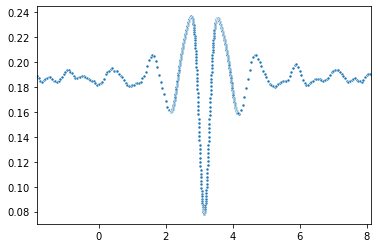

In [10]:
import numpy as np
from numba import njit


@njit(parallel=False)
def nearest_advocate_single(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                            dist_max: float, dist_padding: float, regulate_paddings: bool=True):
    '''Calculates the synchronicity of two arrays of timestamps in terms of the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    dist_max (float): Maximal accepted distances, should be 1/4 of the median gap of arr_ref
    regulate_paddings (bool): Regulate non-overlapping events in arr_sig with a maximum distance of err_max, default True
    dist_padding (float): Distance assigned to non-overlapping (padding) events, should be 1/4 of the median gap of arr_ref. Only given if regulate_paddings is True
    '''
    # Assert input properties
    assert arr_ref.shape[0] > 0    # reference array must be non-empty
    assert arr_sig.shape[0] > 0    # signal array must be non-empty
    assert dist_max > 0.0          # maximal distance must be greater than 0.0
    if regulate_paddings:
        assert dist_padding > 0.0  # maximal distance for paddings must be greater than 0.0

    # store the lengths of the arrays
    l_arr_ref = len(arr_ref)
    l_arr_sig = len(arr_sig)
            
    ref_idx = 0              # index for arr_ref
    sig_idx = 0              # index for arr_sig
    counter = 0              # number of advocate events
    cum_distance = 0.0       # cumulative distances between advocate events
    
    # Step 1: cut leading reference timestamps without finding advocates
    while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
        ref_idx += 1
        
    # return dist_max, if arr_ref ends before arr_sig starts
    if ref_idx+1 == l_arr_ref:
        return dist_max
    
    # Case: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
    assert arr_ref[ref_idx+1] > arr_sig[sig_idx]
    
    # Step 2: count leading signal timestamps with finding advocates
    while sig_idx < l_arr_sig and arr_sig[sig_idx] < arr_ref[ref_idx]:
        # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
        if regulate_paddings:
            cum_distance += min(arr_ref[ref_idx]-arr_sig[sig_idx], dist_padding)
            counter += 1
        sig_idx += 1
        
    # return dist_max, if arr_sig ends before arr_ref starts
    if sig_idx == l_arr_sig:
        return dist_max     
    
    # Step 3 (regular case) and step 4 (match trailing signal timestamps)
    while sig_idx < l_arr_sig:
        # Step 3: regular case
        if arr_sig[sig_idx] < arr_ref[-1]:
            # forward arr_ref and then arr_sig until regalar case
            while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
                ref_idx += 1
            if ref_idx+1 >= l_arr_ref: 
                sig_idx += 1
                continue
            # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
            # assert arr_ref[ref_idx] <= arr_sig[sig_idx]
            # assert arr_sig[sig_idx] < arr_ref[ref_idx+1]
            
            cum_distance += min(arr_sig[sig_idx]-arr_ref[ref_idx], arr_ref[ref_idx+1]-arr_sig[sig_idx], dist_max) 
            counter += 1
        # Step 4: match trailing reference timestamps with last signal timestamp
        elif regulate_paddings:  
            # Invariant: arr_ref[ref_idx+1] <= arr_sig[sig_idx], given by the else case
            if arr_sig[sig_idx]-arr_ref[ref_idx+1] < dist_padding:
                cum_distance += arr_sig[sig_idx]-arr_ref[ref_idx+1]
                counter += 1
            else: 
                # case with only dist_padding increments from now on
                cum_distance += (l_arr_sig - sig_idx) * dist_padding
                counter += (l_arr_sig - sig_idx)
                break # stop, because the last values can be aggregated
                
        sig_idx += 1
    
    # return mean cumulative distance between found advocate events
    return cum_distance / counter


@njit(parallel=False)
def nearest_advocate(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                     td_min: float, td_max: float, td_prox: float=1.0, sps: float=10, sparse_factor: int=1, 
                     dist_max: float=0.0, regulate_paddings: bool=True, dist_padding: float=0.0):
    '''Calculates the synchronicity of two arrays of timestamps for a search space between td_min and td_max with a precision of 1/sps. The synchronicity is given by the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    td_min (float): lower bound of the search space for the time-shift
    td_max (float): upper bound of the search space for the time-shift
    sps (int): number of investigated time-shifts per second, should be higher than 10 times the number of median gap of arr_ref (default 10).
    sparse_factor (int): factor for the sparseness of arr_sig for the calculation, higher is faster but may be less accurate (default 1)
    dist_max (None, float): Maximal accepted distances, default None: 1/4 of the median gap of arr_ref
    dist_padding (None, float): Assumed distances of non-overlapping (padding) matches, default None: 1/4 of the median gap of arr_ref
    regulate_paddings (bool): regulate non-overlapping events in arr_sig with a maximum distance of err_max
    '''
    # set the default values for dist_max, dist_padding relative if not set
    # TODO improve default value: min(np.median(np.diff(arr_sig)), np.median(np.diff(arr_ref))) / 4
    if dist_max <= 0.0:
        dist_max = np.median(np.diff(arr_ref))/4
    if dist_padding <= 0.0:
        dist_padding = np.median(np.diff(arr_ref))/4
        
    # Random subsample and create a copy of arr_sig once, as it could lead to problems otherwise
    if sparse_factor > 1:
        probe = arr_sig[sparse_factor//2::sparse_factor].copy()
    else:
        probe = arr_sig.copy()
    
    # Create an k x 2 matrix to store the investigated time-shifts and their respective mean distance
    broad_search_n_samples = int((td_max-td_min)*sps)
    fine_search_n_samples = int(2*10*td_prox*sps)   # fine search with factor 1/10 sampling
    time_delays = np.empty((broad_search_n_samples+fine_search_n_samples, 2), dtype=np.float32)
    time_delays[:broad_search_n_samples, 0] = np.arange(td_min, td_max, 1/sps)
    # Calculate the mean distance for all time-shifts in the search space. 
    # The shift with the lowest mean distance is the best fit for the time-shift
    idx = 0
    while idx < broad_search_n_samples:
        # calculate the nearest advocate criteria
        time_delays[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-time_delays[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1
    
    # finesearch around the peak
    time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:broad_search_n_samples,1])]
    time_delays[broad_search_n_samples:, 0] = np.arange(time_shift-td_prox, time_shift+td_prox, 1/sps/10)
    # Calculate the mean distance for all time-shifts in the search space. 
    while idx < time_delays.shape[0]:
        # calculate the nearest advocate criteria
        time_delays[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-time_delays[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1     
    return time_delays

# run once before the test to just-in-time compile it
start_time = time.time()
time_delays = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                             td_min=-10, td_max=10, td_prox=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                             dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
print(f"Found optimum for a time shift of {time_shift:.3f}s in {time.time()-start_time:.3f}s")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
plt.xlim(time_shift-5.0, time_shift+5.0)
plt.show()

## Plot the characteristical line of one sample

In [11]:
def plot_nearest_advocate(df_nearest, lb=-10, ub=15, savepath=None, alpha=0.05, cutofflevel=0.5):
    # Plot main stuff and resulting optimum
    # df_nearest["score"] = -(df_nearest["error"] - np.median(df_nearest["error"])) / (np.median(df_nearest["error"]) - np.min(df_nearest["error"]))
    # df_nearest["probability"] = scipy.special.softmax(temperature*(df_nearest["score"]-df_nearest["error"].mean()))
    sns.lineplot(data=df_nearest, x="time-delta", y="error", color="steelblue", label="Distance")
    td_hat = df_nearest.loc[np.argmin(df_nearest["error"])]["time-delta"]
    plt.vlines(x=td_hat, ymin=0, ymax=1, color="firebrick", label=f"Shift = {td_hat:.2f}s")

    # Transform dataframe
    # df_nearest = df_nearest[(lb < df_nearest["time-delta"]) * (df_nearest["time-delta"] < ub)]
    avg = np.median(df_nearest["error"])
    df_nearest["score"] = avg - df_nearest["error"].copy()
    max_score = df_nearest["score"].max();
    df_nearest.loc[df_nearest["score"] < (cutofflevel*max_score), "score"] = 1e-9
    df_nearest["score"] /= df_nearest["score"].sum()
    sns.lineplot(data=df_nearest, x="time-delta", y="score", color="darkturquoise", label="Prob. density")
    
    # Confidence interval
    df_nearest["cumscore"] = df_nearest["score"].cumsum() / df_nearest["score"].sum()
    low_border = df_nearest.loc[df_nearest[df_nearest["cumscore"].gt(alpha/2)].index[0]]
    high_border = df_nearest.loc[df_nearest[df_nearest["cumscore"].gt(1-alpha/2)].index[0]]
    width = high_border['time-delta']-low_border['time-delta']

    # Plot statistics
    avg_prox = time_delay_df.loc[
        (td_hat+lb < time_delay_df["time-delta"]) & (time_delay_df["time-delta"] < td_hat+ub),
        "error"].mean()
    plt.hlines(y=avg_prox, xmin=td_hat+lb, xmax=td_hat+ub, color="black", label="Mean distance")
    b = (avg - df_nearest["error"].min()) #/ 2
    plt.vlines(x=low_border["time-delta"], ymin=0, ymax=1, color="black", linestyle="dashed")
    plt.vlines(x=high_border["time-delta"], ymin=0, ymax=1, color="black", linestyle="dashed", label=f"{100*(1-alpha):.0f}% conf. {width:.1f}s")
    df_peak = df_nearest[(low_border["time-delta"] <= df_nearest["time-delta"]) * (df_nearest["time-delta"] <= high_border["time-delta"])]

    plt.xlim([td_hat+lb, td_hat+ub])
    plt.ylim([-0.01, 1.1*time_delay_df["error"].max()])
    plt.title("Characteristic Curve of Nearest Advocate")
    plt.xlabel("Time shift (s)")
    plt.ylabel("Mean distance (s)")
    
    plt.legend(loc="lower right")
    if savepath:
        plt.savefig(savepath, bbox_inches = "tight")
    plt.show()

In [12]:
arr_ref, arr_sig = heart_beat_dataset[0]
arr_ref = arr_ref[:600]
arr_sig = arr_sig[:600] + np.pi

In [13]:
# run once before the test to just-in-time compile it
start_time = time.time()
DIST_MAX = -1
time_delays = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                             td_min=TD_MIN, td_max=TD_MAX, td_prox=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                             dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
print(f"Found optimum for a time shift of {time_shift:.3f}s in {time.time()-start_time:.3f}s")

Found optimum for a time shift of 2.635s in 0.023s


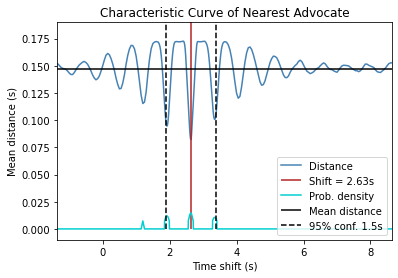

In [14]:
time_delay_df = pd.DataFrame(time_delays, columns=["time-delta", "error"])
plot_nearest_advocate(time_delay_df, 
                      lb=-4, ub=6,
                      alpha=0.05, cutofflevel=0.5, 
                      savepath="fig/real_syncplot_nearestadvocate.png")

## Plot for all heart beat measurements

In [15]:
# for idx, (arr_ref, arr_sig) in enumerate(heart_beat_dataset):
#     print(f"\nFile {idx}")
#     # subset the arrays
#     arr_ref = arr_ref[:1000]
#     arr_sig = arr_sig[:1000]
    
#     # Calculate the time delay
#     start_time = time.time()
#     DIST_MAX = -1
#     time_delays = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
#                                  td_min=TD_MIN, td_max=TD_MAX, td_prox=1, sps=SAMPLES_PER_S, sparse_factor=1, 
#                                  dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
#     time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
#     print(f"Found optimum for a time shift of {time_shift:.3f}s in {time.time()-start_time:.3f}s")
    
#     # plot
#     time_delay_df = pd.DataFrame(time_delays, columns=["time-delta", "error"])
#     plot_nearest_advocate(time_delay_df, 
#                           lb=-7, ub=10,
#                           alpha=0.05, cutofflevel=0.5, 
#                           savepath=None)